In [1]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn

# imports to load some data
from fours.utils.data_handling import load_adi_data

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

from pynpoint.util.analysis import fake_planet

# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(9.5)

In [6]:
data_with_fake_planet = add_fake_planets(
    input_stack=np.zeros_like(science_data),
    psf_template=psf_template,
    parang=angles - np.pi/2, # the pi/2 is to correct the parang to the north
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# The new model

In [13]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class NegFC(nn.Module):

    def __init__(
            self,
            psf_template,
            all_angles,
            input_size,
            init_separation,
            init_pos_angle,
            init_flux_ratio,
            dit_science,
            dit_psf_template,
            nd_factor,
            interpolation="bicubic"
    ):

        super(NegFC, self).__init__()
        self.m_input_size = input_size

        # initialize the three parameters
        self.pos_angle = nn.Parameter(torch.Tensor([init_pos_angle]))
        self.flux_ratio = nn.Parameter(torch.Tensor([init_flux_ratio]))
        self.separation = nn.Parameter(torch.Tensor([init_separation]))
        self.interpolation = interpolation

        # the DIT and ND factor
        # TODO check if nd_factor is 1/nd_factor
        self.integration_time_factor = (
                dit_science / dit_psf_template * nd_factor)

        # save the angles
        self.register_buffer(
            "par_angles",
            torch.from_numpy(all_angles).float())

        # pad the psf template
        pad_size = (self.m_input_size - psf_template.shape[0]) // 2
        if pad_size < 0:
            raise ValueError(
                "The input size is smaller than the PSF template size")

        padded_psf = np.pad(
            psf_template,
            pad_width=((pad_size, pad_size), (pad_size, pad_size)),
            mode='constant',
            constant_values=0)

        self.register_buffer(
            "psf_template",
            torch.from_numpy(padded_psf).float())

    def get_forward_model(self):

        # calculate the correct position angle and x/y shifts
        ang = torch.deg2rad(self.pos_angle) + torch.pi / 2 - self.par_angles

        psf_torch = (self.psf_template *
                     self.flux_ratio *
                     self.integration_time_factor)

        x_shift = self.separation * torch.cos(ang)
        y_shift = self.separation * torch.sin(ang)

        # create the affine matrix
        theta = torch.zeros(ang.shape[0], 2, 3, device=ang.device)
        theta[:, 0, 0] = 1
        theta[:, 1, 1] = 1

        # the -1 is needed because the grid uses align_corners=True
        theta[:, 0, 2] = - x_shift / (psf_torch.shape[0] - 1) * 2
        theta[:, 1, 2] = - y_shift / (psf_torch.shape[1] - 1) * 2

        # build the grid
        grid = F.affine_grid(
            theta,
            torch.Size([ang.shape[0],
                        1,
                        self.m_input_size,
                        self.m_input_size]),
            align_corners=True)

        # apply the grid
        shifted_data = F.grid_sample(
            psf_torch.unsqueeze(0).unsqueeze(0).repeat(
                ang.shape[0], 1, 1, 1),
            grid,
            mode=self.interpolation,
            align_corners=True).squeeze()

        return shifted_data

    def forward(self, science_sequence):
        # get the forward model
        forward_model = self.get_forward_model()

        # apply the forward model
        return science_sequence - forward_model

# test the new model

In [42]:
# create the model
model = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"],
    init_pos_angle=np.deg2rad(fake_planet_config["planet_position"][-1]),
    init_flux_ratio=mag2flux_ratio(9.5),
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0)

In [43]:
model = model.to(0)

In [44]:
fake_planet_sequence = model.get_forward_model()

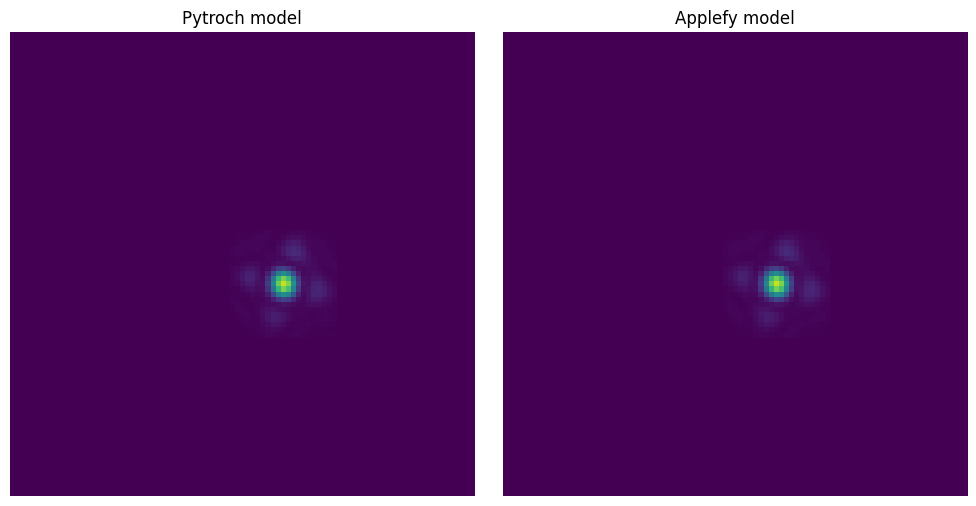

In [45]:
idx = 10000

# plot the fake planet next to the applfy fake planet
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(fake_planet_sequence[idx].detach().cpu().numpy(), vmin=0, vmax=35)
ax1.set_title("Pytroch model")
ax1.axis("off")

ax2.imshow(data_with_fake_planet[idx], vmin=0, vmax=35)
ax2.set_title("Applefy model")
ax2.axis("off")

plt.tight_layout()

In [33]:
np.max(fake_planet_sequence[0].detach().cpu().numpy())

31.231873

In [34]:
np.max(data_with_fake_planet[0])

30.79126822620271